In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Models
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeClassifier, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier 
from sklearn.naive_bayes import GaussianNB

# Import the Data

In [4]:
df = pd.read_csv('Mission_Prediction_Dataset.csv')

In [7]:
df.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','target']

# EDA(Exploratory Data Analysis)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null int64
target      303 non-null int64
dtypes: float64(1), int64(13)
memory usage: 33.2 KB



No missing data 

In [11]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [22]:
corr = df.corr('spearman')
corr.style.background_gradient(cmap='coolwarm')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
age,1,-0.0991309,-0.0874941,0.285617,0.195786,0.113978,-0.132769,-0.398052,0.0896786,0.268291,-0.184048,0.340955,0.0872539,-0.2384
sex,-0.0991309,1,-0.0620409,-0.0529412,-0.151342,0.0450318,-0.0483891,-0.039868,0.141664,0.100715,-0.0250104,0.119368,0.250821,-0.280937
cp,-0.0874941,-0.0620409,1,0.0354132,-0.0917209,0.0897746,0.06564,0.324013,-0.418256,-0.161449,0.159478,-0.216006,-0.20784,0.46086
trestbps,0.285617,-0.0529412,0.0354132,1,0.126562,0.151984,-0.125841,-0.0404074,0.0529182,0.154267,-0.0865695,0.0901396,0.0596728,-0.121593
chol,0.195786,-0.151342,-0.0917209,0.126562,1,0.018463,-0.161933,-0.0467664,0.091514,0.0452596,-0.0125507,0.111981,0.0836279,-0.120888
fbs,0.113978,0.0450318,0.0897746,0.151984,0.018463,1,-0.0815078,-0.0142734,0.0256651,0.0283627,-0.0457855,0.134513,-0.00673739,-0.0280458
restecg,-0.132769,-0.0483891,0.06564,-0.125841,-0.161933,-0.0815078,1,0.0878633,-0.077399,-0.0773723,0.113661,-0.0978619,-0.0109823,0.148612
thalach,-0.398052,-0.039868,0.324013,-0.0404074,-0.0467664,-0.0142734,0.0878633,1,-0.40086,-0.433241,0.436968,-0.257347,-0.160581,0.42837
exang,0.0896786,0.141664,-0.418256,0.0529182,0.091514,0.0256651,-0.077399,-0.40086,1,0.297173,-0.274475,0.162025,0.247113,-0.436757
oldpeak,0.268291,0.100715,-0.161449,0.154267,0.0452596,0.0283627,-0.0773723,-0.433241,0.297173,1,-0.594847,0.224895,0.255026,-0.421487


# Modeling

## Splitting the data

In [12]:
target_name = 'target'
data_target = df[target_name]
data = df.drop([target_name], axis=1)

In [27]:
train_x, test_x, train_y, test_y = train_test_split(data, data_target, test_size=0.3, random_state=0)

## Naive Bayes

In [43]:
gaussian = GaussianNB()
gaussian.fit(train_x, train_y)
acc_gaussian = round(gaussian.score(train_x, train_y) * 100, 2)
acc_gaussian

84.43

In [44]:
acc_test_gaussian = round(gaussian.score(test, target_test) * 100, 2)
acc_test_gaussian

80.22

## Logistic Regression

In [28]:
# Logistic Regression

logreg = LogisticRegression()
logreg.fit(train_x, train_y)
acc_log = round(logreg.score(train_x, train_y) * 100, 2)
acc_log

/Users/alexandremaxinsang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


85.85

In [29]:
acc_test_log = round(logreg.score(test_x, test_y) * 100, 2)
acc_test_log

81.32

## Random Forest

### Hyperparameter Turning

In [56]:
random_forest = GridSearchCV(estimator=RandomForestClassifier(), param_grid={'n_estimators': [25,50,100,150,200]}, cv=5).fit(train, target)
random_forest.fit(train_x, train_y)
acc_random_forest = round(random_forest.score(train_x, train_y) * 100, 2)
print(acc_random_forest,random_forest.best_params_)



/Users/alexandremaxinsang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


100.0 {'n_estimators': 25}


/Users/alexandremaxinsang/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [57]:
acc_test_random_forest = round(random_forest.score(test_x, test_y) * 100, 2)
acc_test_random_forest

84.62

In [58]:
features =train_x.columns

In [59]:
importances = random_forest.best_estimator_.feature_importances_
indices = np.argsort(importances)

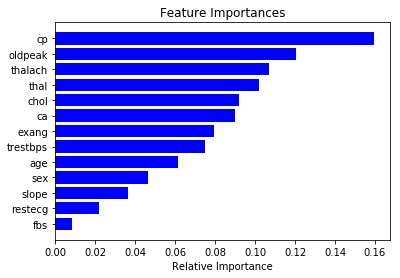

In [62]:
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## XGBoost Classifier